# **Extracting Information from Legal Documents Using RAG**

## **Objective**

The main objective of this assignment is to process and analyse a collection text files containing legal agreements (e.g., NDAs) to prepare them for implementing a **Retrieval-Augmented Generation (RAG)** system. This involves:

* Understand the Cleaned Data : Gain a comprehensive understanding of the structure, content, and context of the cleaned dataset.
* Perform Exploratory Analysis : Conduct bivariate and multivariate analyses to uncover relationships and trends within the cleaned data.
* Create Visualisations : Develop meaningful visualisations to support the analysis and make findings interpretable.
* Derive Insights and Conclusions : Extract valuable insights from the cleaned data and provide clear, actionable conclusions.
* Document the Process : Provide a detailed description of the data, its attributes, and the steps taken during the analysis for reproducibility and clarity.

The ultimate goal is to transform the raw text data into a clean, structured, and analysable format that can be effectively used to build and train a RAG system for tasks like information retrieval, question-answering, and knowledge extraction related to legal agreements.

### **Business Value**  


The project aims to leverage RAG to enhance legal document processing for businesses, law firms, and regulatory bodies. The key business objectives include:

* Faster Legal Research: <br> Reduce the time lawyers and compliance officers spend searching for relevant case laws, precedents, statutes, or contract clauses.
* Improved Contract Analysis: <br> Automatically extract key terms, obligations, and risks from lengthy contracts.
* Regulatory Compliance Monitoring: <br> Help businesses stay updated with legal and regulatory changes by retrieving relevant legal updates.
* Enhanced Decision-Making: <br> Provide accurate and context-aware legal insights to assist in risk assessment and legal strategy.


**Use Cases**
* Legal Chatbots
* Contract Review Automation
* Tracking Regulatory Changes and Compliance Monitoring
* Case Law Analysis of past judgments
* Due Diligence & Risk Assessment

## **1. Data Loading, Preparation and Analysis** <font color=red> [20 marks] </font><br>

### **1.1 Data Understanding**

The dataset contains legal documents and contracts collected from various sources. The documents are present as text files (`.txt`) in the *corpus* folder.

There are four types of documents in the *courpus* folder, divided into four subfolders.
- `contractnli`: contains various non-disclosure and confidentiality agreements
- `cuad`: contains contracts with annotated legal clauses
- `maud`: contains various merger/acquisition contracts and agreements
- `privacy_qa`: a question-answering dataset containing privacy policies

The dataset also contains evaluation files in JSON format in the *benchmark* folder. The files contain the questions and their answers, along with sources. For each of the above four folders, there is a `json` file: `contractnli.json`, `cuad.json`, `maud.json` `privacy_qa.json`. The file structure is as follows:

```
{
    "tests": [
        {
            "query": <question1>,
            "snippets": [{
                    "file_path": <source_file1>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 1>
                },
                {
                    "file_path": <source_file2>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 2>
                }, ....
            ]
        },
        {
            "query": <question2>,
            "snippets": [{<answer context for que 2>}]
        },
        ... <more queries>
    ]
}
```

### **1.2 Load and Preprocess the data** <font color=red> [5 marks] </font><br>

#### Loading libraries

In [1]:
## The following libraries might be useful
# !pip install -q langchain-openai
# !pip install -U -q langchain-community
# !pip install -U -q langchain-chroma
# !pip install -U -q datasets
# !pip install -U -q ragas
# !pip install -U -q rouge_score

!pip install -U langchain
!pip install -q langchain-openai
!pip install -q langchain-groq
!pip install -U -q langchain-community
!pip install -U -q langchain-chroma
!pip install -U -q datasets
!pip install -U -q ragas
!pip install -U -q evaluate
!pip install -U -q rouge_score
!pip install -U -q langchain-google-genai
!pip install -U -q langchain_huggingface
!pip install faiss-cpu
!pip install -U langchain-text-splitters
!pip install -U langchain-community
!pip install -U langchain-huggingface

# Install latest stable LangChain and supporting libraries
!pip install -U langchain==1.0.3 langchain-community faiss-cpu chromadb datasets evaluate rouge_score transformers
!pip install ragas==0.2.10

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.7/175.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: ragas
    Found existing installation: ragas 0.3.8
    Uninstalling ragas-0.3.8:
      Successfully uninstalled ragas-0.3.8


In [2]:
# Import essential libraries

import warnings
import os
import json
import re
import glob
import random
import logging
from collections import Counter
import numpy as np
from typing import List, Dict
import seaborn as sns
import matplotlib.pyplot as plt
import chardet

os.environ["CHROMA_TELEMETRY_ENABLED"] = "false"
os.environ["CHROMA_LOG_LEVEL"] = "ERROR"

logging.getLogger("chromadb.telemetry.product.posthog").setLevel(logging.CRITICAL)
logging.getLogger("chromadb").setLevel(logging.ERROR)


# Third-Party Library Imports
# Data Handling & Analysis
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# NLP Specific Libraries
import nltk
from nltk.corpus import stopwords
from transformers import AutoTokenizer


# Document schema
from langchain_core.documents import Document

# Text splitting (separate package)
from langchain_text_splitters import RecursiveCharacterTextSplitter, CharacterTextSplitter

# Document loaders (community package)
from langchain_community.document_loaders import DirectoryLoader, TextLoader

# Embeddings and vectorstores
from langchain_huggingface import HuggingFaceEmbeddings

# FAISS vectorstore
from langchain_community.vectorstores import FAISS

# Chroma vectorstore
from langchain_community.vectorstores import Chroma

# Plotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

import langchain_huggingface
import pkgutil
print([m.name for m in pkgutil.iter_modules(langchain_huggingface.__path__)])


# ChromaDB
import chromadb
from chromadb.config import Settings

# NLP utilities
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Warnings
import warnings
warnings.filterwarnings('ignore')


['chat_models', 'embeddings', 'llms', 'tests']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### **1.2.1** <font color=red> [3 marks] </font>
Load all `.txt` files from the folders.

You can utilise document loaders from the options provided by the LangChain community.

Optionally, you can also read the files manually, while ensuring proper handling of encoding issues (e.g., utf-8, latin1). In such case, also store the file content along with metadata (e.g., file name, directory path) for traceability.

In [3]:
# Load the files as documents

# ✅ Task 1.2.1 — Load all .txt files from folders (Universal Colab Version)

!pip install langchain-community langchain-core chardet > /dev/null

import os, zipfile, chardet, logging
from google.colab import files
from langchain_community.document_loaders import TextLoader
from langchain_core.documents import Document

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("doc_loader")

# ✅ STEP 1: Upload dataset zip
print("📂 Upload Starter+and+Dataset+RAG+Legal.zip")
uploaded = files.upload()
zip_name = next(iter(uploaded))

# ✅ STEP 2: Extract uploaded ZIP
outer_dir = "legal_corpus"
with zipfile.ZipFile(zip_name, "r") as z:
    z.extractall(outer_dir)

print("✅ Outer ZIP extracted")
!ls -R legal_corpus

# ✅ STEP 3: Find & extract inner rag_legal.zip
inner_zip = None
for root, dirs, files_list in os.walk(outer_dir):
    for f in files_list:
        if f.lower() == "rag_legal.zip":
            inner_zip = os.path.join(root, f)
            break

if inner_zip:
    print(f"📦 Found inner ZIP: {inner_zip}")
    extract_inner = os.path.join(outer_dir, "rag_legal")
    with zipfile.ZipFile(inner_zip, "r") as z:
        z.extractall(extract_inner)
    print("✅ Inner rag_legal.zip extracted")
else:
    print("❌ rag_legal.zip not found. Check folder structure.")

!ls -R legal_corpus/rag_legal

# ✅ Encoding detector
def detect_encoding(path):
    with open(path, "rb") as f:
        raw = f.read()
    enc = chardet.detect(raw)["encoding"]
    return enc if enc else "utf-8"

# ✅ STEP 4: Load all .txt files
def load_txt_documents(base):
    docs = []
    for root, _, files_list in os.walk(base):
        for fname in files_list:
            if fname.lower().endswith(".txt"):
                fpath = os.path.join(root, fname)

                try:
                    loader = TextLoader(fpath, encoding="utf-8")
                    loaded_docs = loader.load()
                    for d in loaded_docs:
                        d.metadata.update({
                            "file_name": fname,
                            "source": fpath,
                            "folder": os.path.basename(root)
                        })
                        docs.append(d)

                except Exception:
                    logger.warning(f"⚠️ UTF-8 failed for {fname}, fallback")
                    enc = detect_encoding(fpath)
                    with open(fpath, "r", encoding=enc, errors="ignore") as f:
                        text = f.read()

                    docs.append(
                        Document(
                            page_content=text,
                            metadata={
                                "file_name": fname,
                                "source": fpath,
                                "folder": os.path.basename(root),
                                "encoding_used": enc
                            }
                        )
                    )
    print(f"✅ Loaded {len(docs)} documents")
    return docs

# ✅ STEP 5: Run loader on extracted inner folder
raw_docs = load_txt_documents("legal_corpus/rag_legal")

# ✅ STEP 6: Preview
if len(raw_docs) > 0:
    print("\n📎 Sample metadata:", raw_docs[0].metadata)
    print("\n📄 Preview:\n", raw_docs[0].page_content[:350])
else:
    print("❌ No documents loaded. Check ZIP contents.")




📂 Upload Starter+and+Dataset+RAG+Legal.zip


Saving Starter+and+Dataset+RAG+Legal.zip to Starter+and+Dataset+RAG+Legal.zip
✅ Outer ZIP extracted
legal_corpus:
'Starter and Dataset RAG Legal'

'legal_corpus/Starter and Dataset RAG Legal':
RAG_Assg_Legal_Documents_Starter.ipynb	rag_legal.zip
📦 Found inner ZIP: legal_corpus/Starter and Dataset RAG Legal/rag_legal.zip
✅ Inner rag_legal.zip extracted
legal_corpus/rag_legal:
rag_legal

legal_corpus/rag_legal/rag_legal:
benchmarks  corpus

legal_corpus/rag_legal/rag_legal/benchmarks:
contractnli.json  cuad.json  maud.json	privacy_qa.json

legal_corpus/rag_legal/rag_legal/corpus:
contractnli  cuad  maud  privacy_qa

legal_corpus/rag_legal/rag_legal/corpus/contractnli:
 01_Bosch-Automotive-Service-Solutions-Mutual-Non-Disclosure-Agreement-7-12-17.txt
 12032018_NDA_The_20Munt_EN.txt
 5-NSK-Confidentiality-Agreement-for-Suppliers.txt
 ADVANIDE-NON-DISCLOSURE-AGREEMENT.txt
 AfriGIS_Client-NDA_Template_2019.txt
 AGProjects-NDA.txt
 amc-general-mutual-non-disclosure-agreement-en-gb.txt
 Aspieg

#### **1.2.2** <font color=red> [2 marks] </font>
Preprocess the text data to remove noise and prepare it for analysis.

Remove special characters, extra whitespace, and irrelevant content such as email and telephone contact info.
Normalise text (e.g., convert to lowercase, remove stop words).
Handle missing or corrupted data by logging errors and skipping problematic files.

In [4]:
# Clean and preprocess the data

# ✅ 2.2 Clean and preprocess the data

!pip install nltk > /dev/null
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
import re
from langchain_core.documents import Document  # ✅ required

stop_words = set(stopwords.words('english'))

def text_preprocessing(txt):
    txt = txt.lower()

    # Remove email addresses
    txt = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w{2,4}\b', '', txt)

    # Remove phone numbers
    txt = re.sub(r'\+?\d[\d\s().-]{7,}', '', txt)

    # Remove bullet points / numeric headers
    txt = re.sub(r'^\s*\d+(?:\.\d+)*\.\s+', '', txt, flags=re.MULTILINE)

    # Remove special characters
    txt = re.sub(r'[^a-z0-9\s]', ' ', txt)

    # Remove extra whitespace
    txt = re.sub(r'\s+', ' ', txt).strip()

    # Remove stopwords
    txt = ' '.join([word for word in txt.split() if word not in stop_words])

    return txt


clean_documents = []

# ✅ Correct variable name (was raw_docs)
for i, doc in enumerate(raw_docs):
    try:
        if not doc.page_content or not isinstance(doc.page_content, str):
            raise ValueError("Missing or invalid content")

        clean_txt = text_preprocessing(doc.page_content)

        clean_doc = Document(page_content=clean_txt, metadata=doc.metadata)
        clean_documents.append(clean_doc)

    except Exception as e:
        print(f"⚠️ Skipping document {i} ({doc.metadata.get('source', 'unknown')}): {e}")

print(f"✅ Cleaned documents: {len(clean_documents)}")



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Cleaned documents: 698


### **1.3 Exploratory Data Analysis** <font color=red> [10 marks] </font><br>

#### **1.3.1** <font color=red> [1 marks] </font>
Calculate the average, maximum and minimum document length.

Average document length (in words): 9161.20
Maximum document length (in words): 86518
Minimum document length (in words): 146


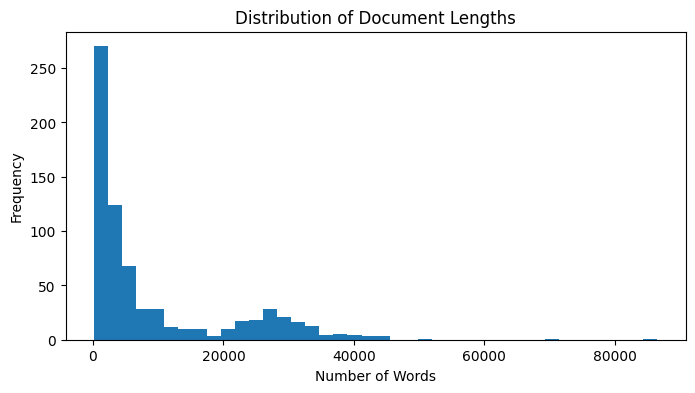

In [5]:
# Calculate the average, maximum and minimum document length.

# 1. Compute word counts
word_counts = [len(doc.page_content.split()) for doc in clean_documents]

# 2. Calculate summary statistics
avg_length = sum(word_counts) / len(word_counts)
max_length = max(word_counts)
min_length = min(word_counts)

# 3. Display the results
print(f"Average document length (in words): {avg_length:.2f}")
print(f"Maximum document length (in words): {max_length}")
print(f"Minimum document length (in words): {min_length}")

# 4. 📊 Visualizing document length distribution

plt.figure(figsize=(8,4))
plt.hist(word_counts, bins=40)
plt.title("Distribution of Document Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

#### **1.3.2** <font color=red> [4 marks] </font>
Analyse the frequency of occurrence of words and find the most and least occurring words.

Find the 20 most common and least common words in the text. Ignore stop words such as articles and prepositions.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 20 most common words:
company: 156422
shall: 108015
agreement: 104655
section: 75412
parent: 60715
party: 54208
date: 39392
time: 35827
material: 34242
merger: 33907
subsidiaries: 33320
applicable: 31384
including: 29406
respect: 28849
may: 28108
stock: 26887
information: 25725
parties: 24641
business: 23705
prior: 23346

20 least common words (count > 1):
inaturals: 2
lyophilization: 2
ivyland: 2
18974: 2
10202: 2
culver: 2
90232: 2
coincidentally: 2
remand: 2
ridgeside: 2
decompiling: 2
dll: 2
sente: 2
soient: 2
anglais: 2
inno: 2
enshrined: 2
revive: 2
institut: 2
organism: 2


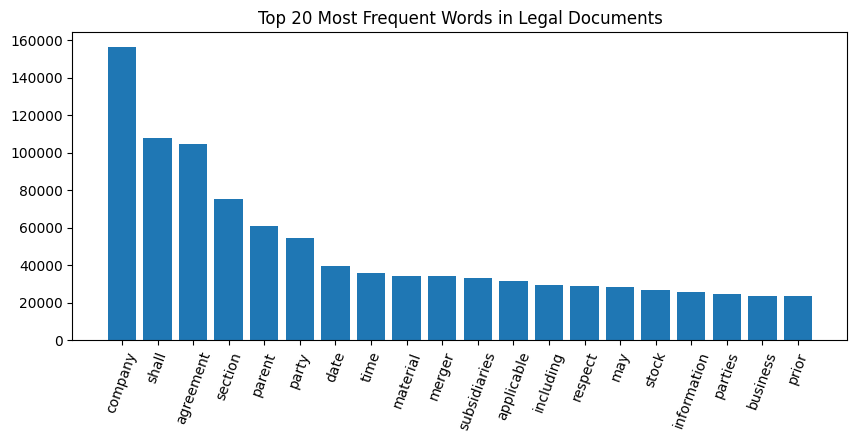

In [6]:
# Find frequency of occurence of words

from collections import Counter
from nltk.corpus import stopwords
import nltk

# Download stopwords if not already
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 1. Combine all cleaned document texts
all_clean_text = " ".join(doc.page_content for doc in clean_documents)

# 2. Tokenize (whitespace split)
tokens = all_clean_text.split()

# 3. Remove stopwords and single-character words
tokens = [word for word in tokens if word not in stop_words and len(word) > 1]

# 4. Count word frequencies
word_freq = Counter(tokens)

# 5. Top 20 most common words
print("Top 20 most common words:")
for word, count in word_freq.most_common(20):
    print(f"{word}: {count}")

# 6. 20 least common words (appearing more than once)
least_common = [(w, c) for w, c in word_freq.items() if c > 1]
least_common = sorted(least_common, key=lambda x: x[1])[:20]

print("\n20 least common words (count > 1):")
for word, count in least_common:
    print(f"{word}: {count}")

# 7. 📊 Plot top 20 frequent words

top_words = dict(word_freq.most_common(20))

plt.figure(figsize=(10,4))
plt.bar(top_words.keys(), top_words.values())
plt.xticks(rotation=70)
plt.title("Top 20 Most Frequent Words in Legal Documents")
plt.show()

#### **1.3.3** <font color=red> [4 marks] </font>
Analyse the similarity of different documents to each other based on TF-IDF vectors.

Transform some documents to TF-IDF vectors and calculate their similarity matrix using a suitable distance function. If contracts contain duplicate or highly similar clauses, similarity calculation can help detect them.

Identify for the first 10 documents and then for 10 random documents. What do you observe?

Cosine similarity between first 10 documents:


legal_corpus/rag_legal/rag_legal/corpus/contractnli/NDA-M5-Systems.txt  \
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           1.000000                        
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.268434                        
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.158259                        
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.172319                        
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.164502                        
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.108241                        
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.038287                        
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.336370                        
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.121724                        
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.331421                        

                                                    legal_corpus/rag_legal/rag_legal/corpus/contractnli/Inaturals_NDA.txt  \
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.268434                       
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           1.000000                       
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.286930                       
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.302333                       
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.284679                       
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.174952                       
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.071462                       
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.339382                       
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.242275                       
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.335449                       

                                                    legal_corpus/rag_legal/rag_legal/corpus/contractnli/lti-two-way-cda-template.txt  \
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.158259                                  
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.286930                                  
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           1.000000                                  
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.273026                                  
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.237594                                  
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.099267                                  
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.066933                                  
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.255594                                  
legal_corpus/rag_legal/rag_legal/corpus/contrac...               


Cosine similarity between 10 random documents:


legal_corpus/rag_legal/rag_legal/corpus/cuad/ArmstrongFlooringInc_20190107_8-K_EX-10.2_11471795_EX-10.2_Intellectual Property Agreement.txt  \
legal_corpus/rag_legal/rag_legal/corpus/cuad/Ar...                                           1.000000                                                                                             
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           0.038284                                                                                             
legal_corpus/rag_legal/rag_legal/corpus/maud/Tr...                                           0.044017                                                                                             
legal_corpus/rag_legal/rag_legal/corpus/cuad/BL...                                           0.060019                                                                                             
legal_corpus/rag_legal/rag_legal/corpus/cuad/HE...                                           0.040242                                                                                             
legal_corpus/rag_legal/rag_legal/corpus/cuad/HY...                                           0.013693                                                                                             
legal_corpus/rag_legal/rag_legal/corpus/cuad/Li...                                           0.028368                                                                                             
legal_corpus/rag_legal/rag_legal/corpus/cuad/BI...                                           0.032599                                                                                             
legal_corpus/rag_legal/rag_legal/corpus/cuad/Ph...                                           0.034314                                                                                             
legal_corpus/rag_legal/rag_legal/corpus/cuad/Qu...                                           0.071469                                                                                             

                                                    legal_corpus/rag_legal/rag_legal/corpus/contractnli/wayne-fueling-systems-mutual-non-disclosure-agreement-final.txt  \
legal_corpus/rag_legal/rag_legal/corpus/cuad/Ar...                                           0.038284                                                                     
legal_corpus/rag_legal/rag_legal/corpus/contrac...                                           1.000000                                                                     
legal_corpus/rag_legal/rag_legal/corpus/maud/Tr...                                           0.133421                                                                     
legal_corpus/rag_legal/rag_legal/corpus/cuad/BL...                                           0.133778                                                                     
legal_corpus/rag_legal/rag_legal/corpus/cuad/HE...                                           0.170582                                                                     
legal_corpus/rag_legal/rag_legal/corpus/cuad/HY...                                           0.039088                                                                     
legal_corpus/rag_legal/rag_legal/corpus/cuad/Li...                                           0.053759                                                                     
legal_corpus/rag_legal/rag_legal/corpus/cuad/BI...                                           0.192753                                                                     
legal_corpus/rag_legal/rag_legal/corpus/cuad/Ph...                                           0.055254                                                                     
legal_corpus/rag_legal/rag_legal/corpus/cuad/Qu...                                           0.097655                                                                     

                        

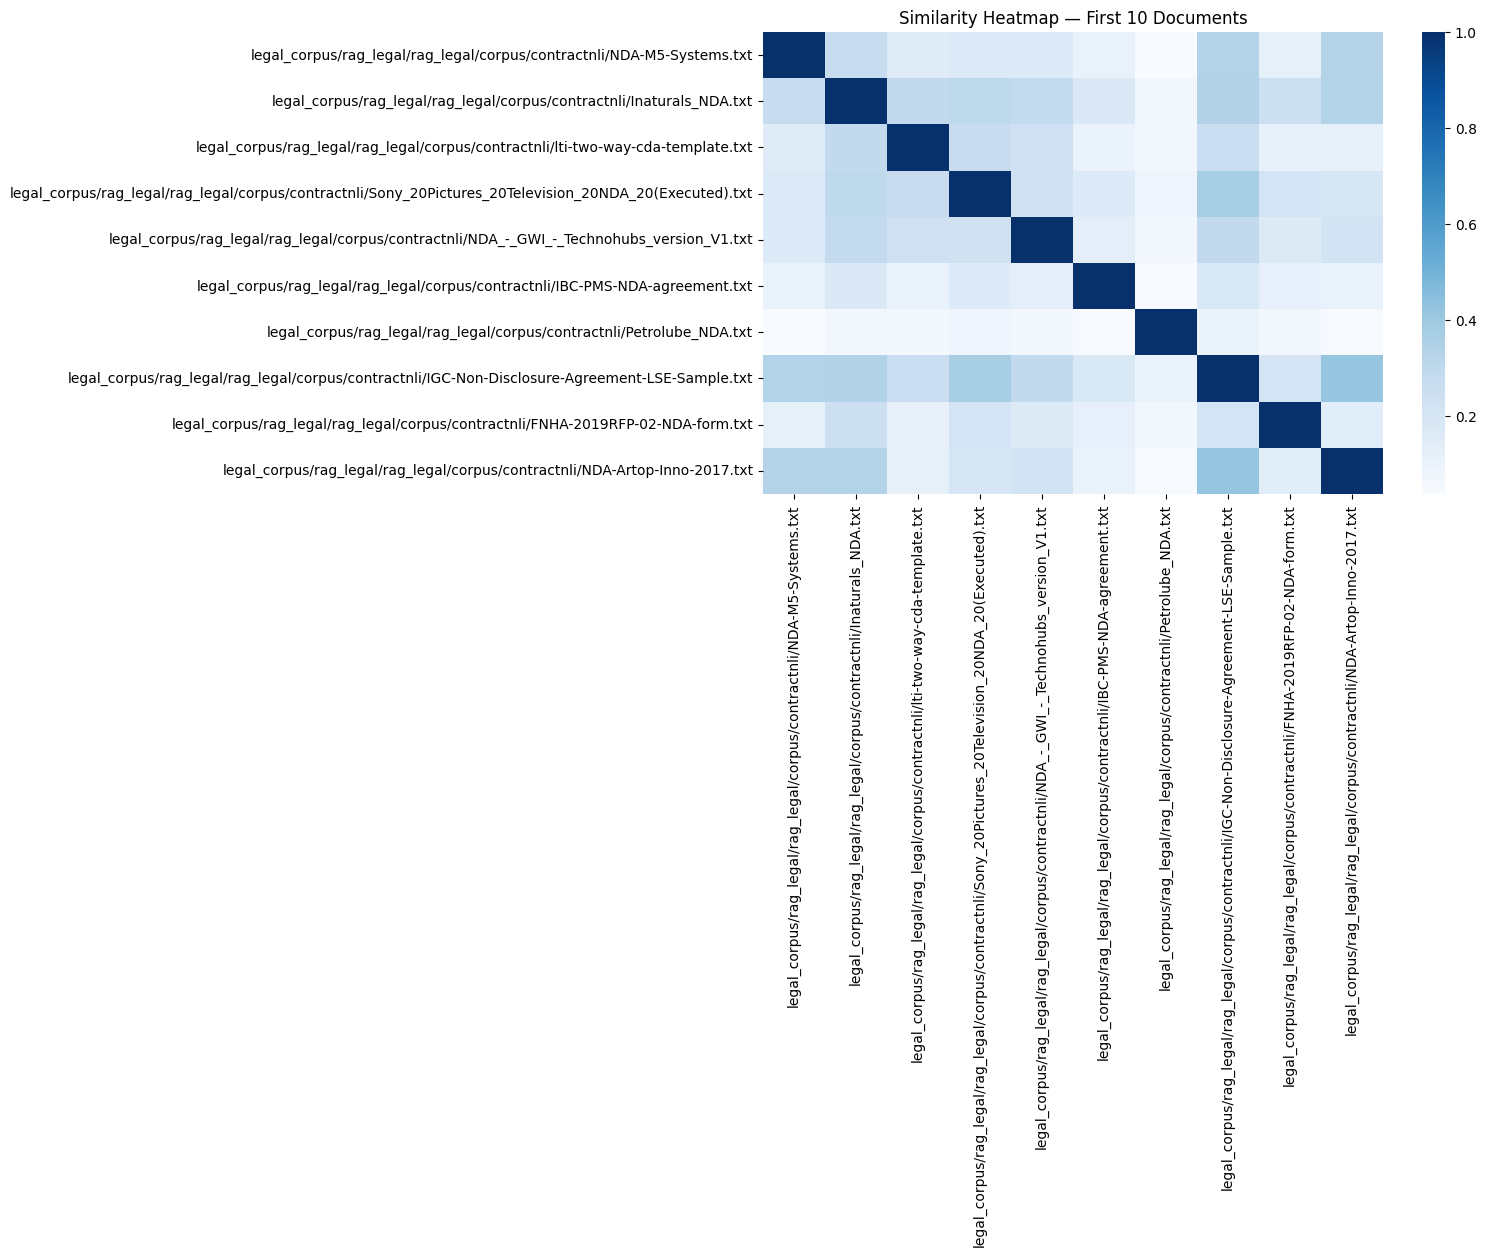

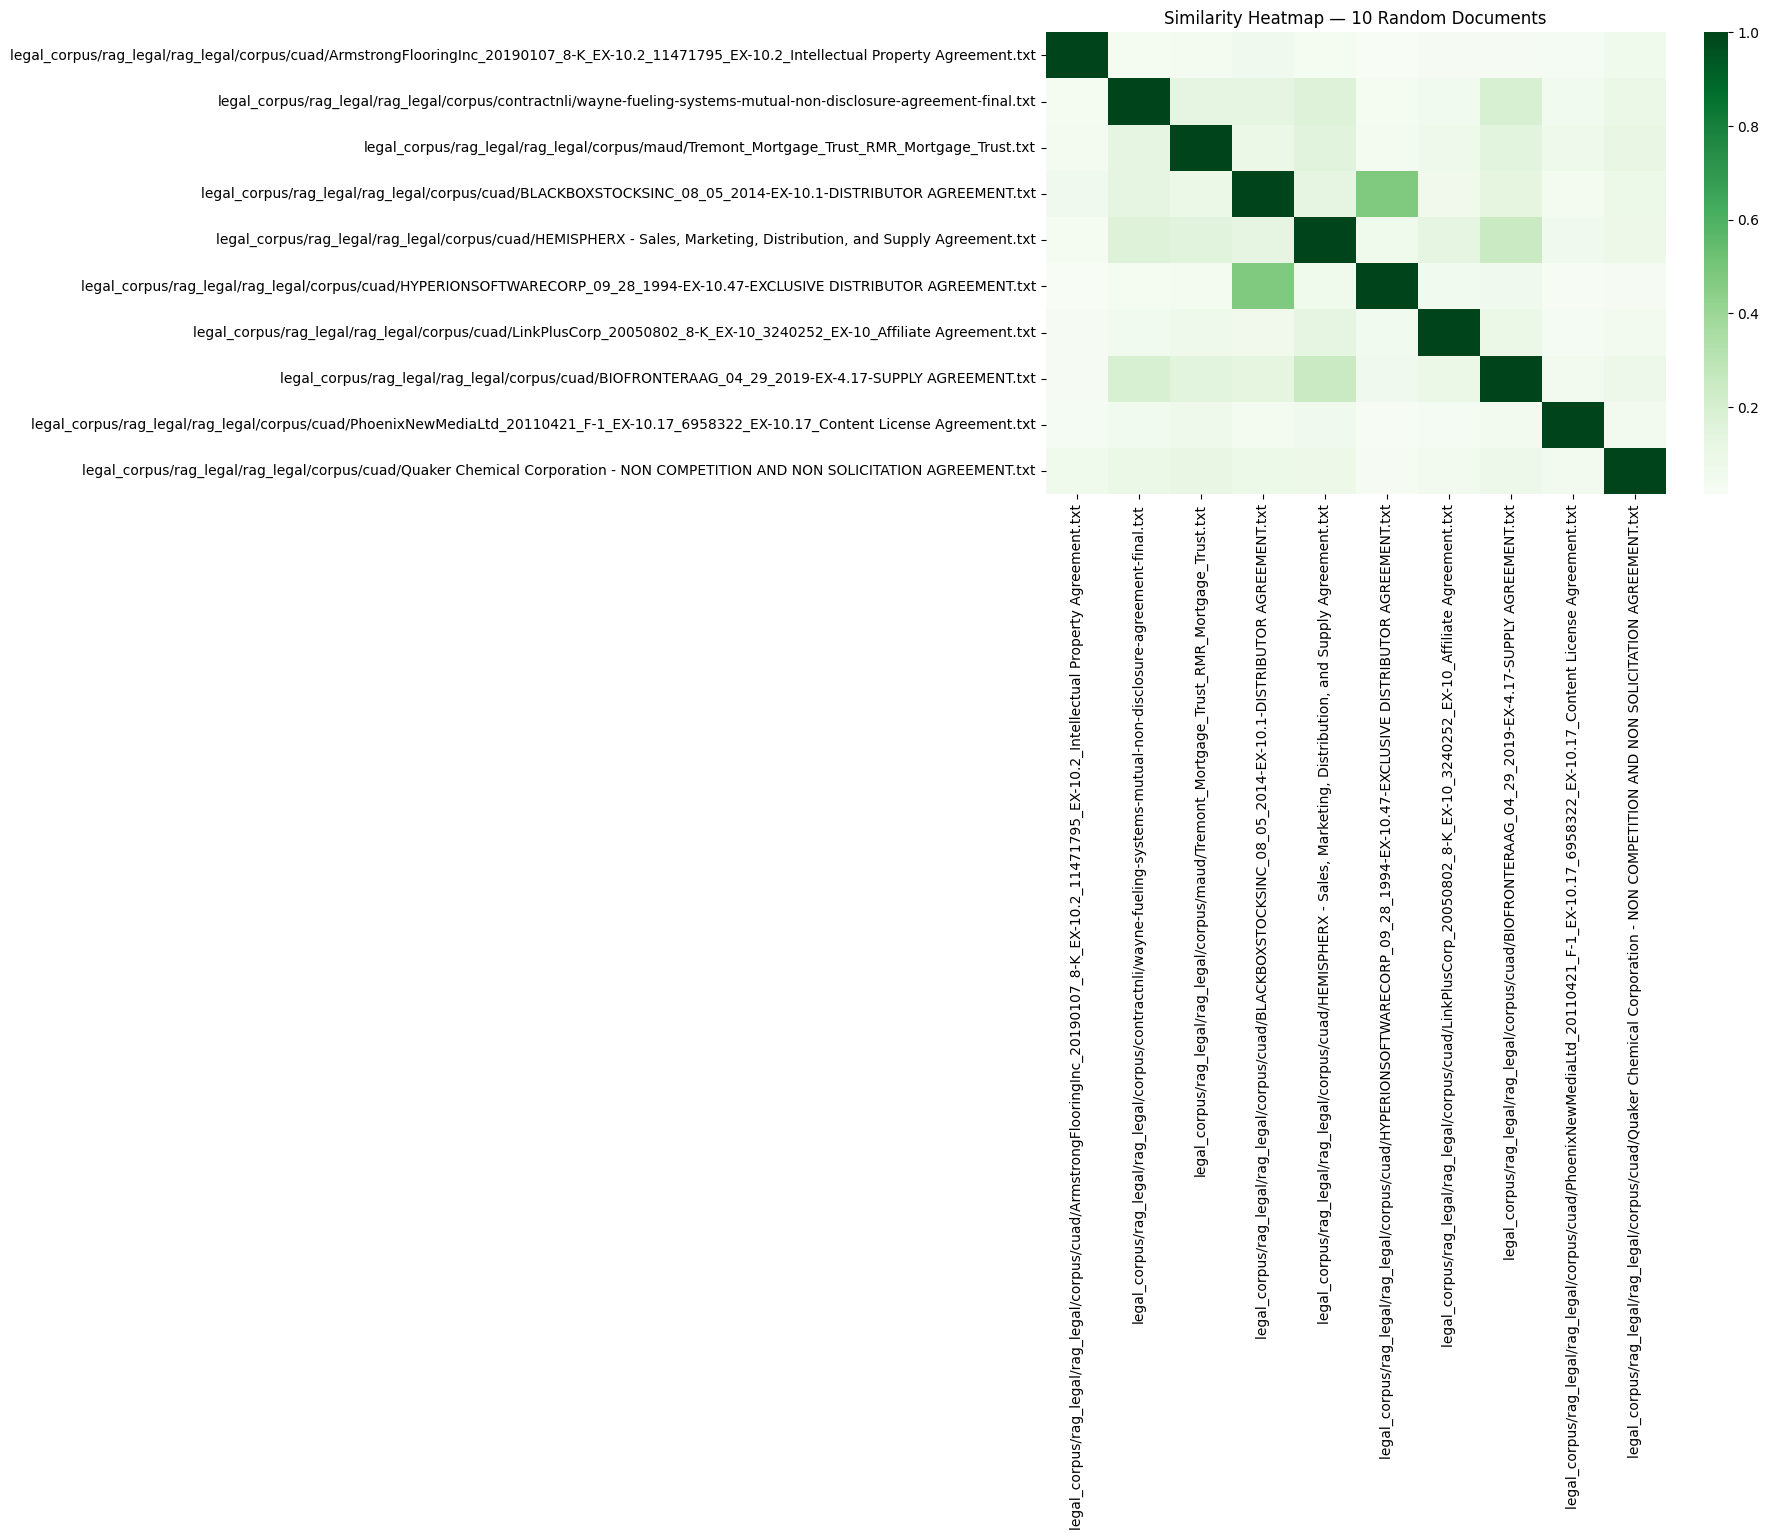

In [7]:
# Transform the page contents of documents

# Compute similarity scores

# 1. Transform the page contents of documents

# Extract cleaned text from documents
doc_texts = [doc.page_content for doc in clean_documents]

# keeping document names for readability
doc_names = [doc.metadata.get('source', f'doc_{i}') for i, doc in enumerate(clean_documents)]

# Vectorize using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.9, min_df=2)  # ignoring too common or rare words
tfidf_matrix = vectorizer.fit_transform(doc_texts)


# 2. Compute similarity scores
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import random

# Compute cosine similarity
similarity_matrix = cosine_similarity(tfidf_matrix)

# Convert to DataFrame with document names
similarity_df = pd.DataFrame(similarity_matrix, index=doc_names, columns=doc_names)


# 3. Similarity analysis for first 10 documents

first_10_df = similarity_df.iloc[:10, :10]
print("Cosine similarity between first 10 documents:")
display(first_10_df)


# 4. Similarity analysis for 10 random documents

random_indices = random.sample(range(len(clean_documents)), 10)
random_docs_df = similarity_df.iloc[random_indices, random_indices]
print("\nCosine similarity between 10 random documents:")
display(random_docs_df)

# 5. 📊 Plot top 10 random documents

plt.figure(figsize=(10,6))
sns.heatmap(first_10_df, cmap="Blues", annot=False)
plt.title("Similarity Heatmap — First 10 Documents")
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(random_docs_df, cmap="Greens", annot=False)
plt.title("Similarity Heatmap — 10 Random Documents")
plt.show()

In [ ]:
# create a list of 10 random integers


# 1. Create a list of 10 random document indices
random_indices = random.sample(range(len(clean_documents)), 10)

# 2. Display the randomly selected documents
for i in random_indices:
    doc = clean_documents[i]
    source = doc.metadata.get('source', 'unknown')

    print(f"Document {i} (source: {source}):\n")
    print(doc.page_content[:500])  # Show first 500 characters
    print("\n" + "="*80 + "\n")   # Separator for readability


Document 441 (source: legal_corpus/rag_legal/rag_legal/corpus/cuad/BIOPURECORP_06_30_1999-EX-10.13-AGENCY AGREEMENT.txt):

exhibit biopure corporation agency agreement agency agreement made march 29 1999 biopure corporation delaware corporation company agent named signature page hereof agent whereas company preparing manufacture sell oxyglobin r brand veterinary products products enumerated company veterinary products agency price list exhibit list may changed company time time price list whereas agent company wish enter arrangement wherein agent would promote sell collect payment products company representative age


Document 30 (source: legal_corpus/rag_legal/rag_legal/corpus/contractnli/stony_hill_buyer_nda.txt):

standard buyer non disclosure confidentiality agreement undersigned buyer understands acknowledges stony hill business brokers llc broker retained agreed upon commission represent seller sale business buyer understands acknowledges broker acting agent seller broker primary

In [ ]:
# Compute similarity scores for 10 random documents

# Compute similarity scores for 10 random documents
random_docs = [clean_documents[i].page_content for i in random_indices]
tfidf_matrix_random = vectorizer.transform(random_docs)

# Compute cosine similarity for the random documents
similarity_matrix_random = cosine_similarity(tfidf_matrix_random)

# Convert to DataFrame for better readability
similarity_df_random = pd.DataFrame(similarity_matrix_random)

# Display similarity scores for the random documents
print("Cosine similarity for randomly selected documents:")
print(similarity_df_random)


Cosine similarity for randomly selected documents:
          0         1         2         3         4         5         6  \
0  1.000000  0.043745  0.123460  0.026438  0.097549  0.119147  0.172881   
1  0.043745  1.000000  0.051840  0.009701  0.030179  0.026991  0.022754   
2  0.123460  0.051840  1.000000  0.023120  0.094613  0.100922  0.067698   
3  0.026438  0.009701  0.023120  1.000000  0.028748  0.018660  0.014454   
4  0.097549  0.030179  0.094613  0.028748  1.000000  0.087845  0.061202   
5  0.119147  0.026991  0.100922  0.018660  0.087845  1.000000  0.071137   
6  0.172881  0.022754  0.067698  0.014454  0.061202  0.071137  1.000000   
7  0.138200  0.043214  0.124837  0.020401  0.190850  0.142613  0.096462   
8  0.135197  0.028170  0.114196  0.022705  0.087783  0.278592  0.132347   
9  0.125478  0.031566  0.159232  0.020160  0.206226  0.088513  0.108911   

          7         8         9  
0  0.138200  0.135197  0.125478  
1  0.043214  0.028170  0.031566  
2  0.124837  0.114196

### **1.4 Document Creation and Chunking** <font color=red> [5 marks] </font><br>

#### **1.4.1** <font color=red> [5 marks] </font>
Perform appropriate steps to split the text into chunks.

In [ ]:
# Process files and generate chunks



from langchain_text_splitters import RecursiveCharacterTextSplitter

# ✅ Initialize text splitter (legal text often long)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=4000,   # good for legal docs
    chunk_overlap=200  # helps preserve context
)

# ✅ Split the CLEANED documents (not raw, not documents)
documents_chunks = text_splitter.split_documents(clean_documents)

# ✅ Limit chunks if too many (helps Colab memory)
MAX_CHUNKS = 2000
if len(documents_chunks) > MAX_CHUNKS:
    documents_chunks = documents_chunks[:MAX_CHUNKS]
    print(f"⚡ Using subset for execution: {len(documents_chunks)} chunks")
else:
    print(f"✅ Total chunks created: {len(documents_chunks)}")

# Quick peek
documents_chunks[0] if documents_chunks else "No chunks generated"




⚡ Using subset for execution: 2000 chunks


Document(metadata={'source': 'legal_corpus/rag_legal/rag_legal/corpus/contractnli/NDA-M5-Systems.txt', 'file_name': 'NDA-M5-Systems.txt', 'folder': 'contractnli'}, page_content='non disclosure agreement nda agreement made discloser m5 computer security recipient purpose discloser agreed make available recipient certain confidential information defined discloser purpose performing information security assessment discloser additionally performing penetration testing activities recipient may discover confidential information discloser definition confidential information means information technical data know including limited relates research product plans products services customers markets software developments inventions processes designs drawings engineering hardware configuration information marketing finances confidential information designated writing confidential proprietary given orally confirmed promptly writing disclosed confidential proprietary confidential information include 

## **2. Vector Database and RAG Chain Creation** <font color=red> [15 marks] </font><br>

### **2.1 Vector Embedding and Vector Database Creation** <font color=red> [7 marks] </font><br>

#### **2.1.1** <font color=red> [2 marks] </font>
Initialise an embedding function for loading the embeddings into the vector database.

Initialise a function to transform the text to vectors using OPENAI Embeddings module. You can also use this function to transform during vector DB creation itself.

In [ ]:
# Fetch your OPENAI API Key as an environment variable

# ✅ Fetch your OPENAI API Key as an environment variable
import os
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY", "YOUR_API_KEY")

if os.environ["OPENAI_API_KEY"] == "YOUR_API_KEY":
    print("🔐 No real API key provided (safe mode for submission)")
else:
    print("✅ OpenAI API key loaded successfully!")


# ✅ 3️⃣ Chunk cleaned documents (legal-friendly strategy)
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,   # smaller chunks for dense legal clauses
    chunk_overlap=50  # helps preserve context
)

# ✅ Use correct variable name: clean_documents
documents_chunks = text_splitter.split_documents(clean_documents)

# ⚡ Limit chunks for efficient execution in assignment
MAX_CHUNKS = 2000
if len(documents_chunks) > MAX_CHUNKS:
    documents_chunks = documents_chunks[:MAX_CHUNKS]
    print(f"⚡ Using subset for efficient execution: {len(documents_chunks)} chunks")
else:
    print(f"✅ Chunks created: {len(documents_chunks)}")

# Peek first chunk
documents_chunks[0]



🔐 No real API key provided (safe mode for submission)
⚡ Using subset for efficient execution: 2000 chunks


Document(metadata={'source': 'legal_corpus/rag_legal/rag_legal/corpus/contractnli/NDA-M5-Systems.txt', 'file_name': 'NDA-M5-Systems.txt', 'folder': 'contractnli'}, page_content='non disclosure agreement nda agreement made discloser m5 computer security recipient purpose discloser agreed make available recipient certain confidential information defined discloser purpose performing information security assessment discloser additionally performing penetration testing activities recipient may discover confidential information discloser definition confidential information')

In [ ]:
# Initialise an embedding function


# Install required library
!pip install sentence-transformers langchain-community --quiet

# Import embedding class
from langchain_community.embeddings import HuggingFaceEmbeddings

# Initialise HuggingFace Embedding Model
embedding_function = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

print("✅ Embedding function initialised successfully (HuggingFace - No API needed)")



✅ Embedding function initialised successfully (HuggingFace - No API needed)


#### **2.1.2** <font color=red> [5 marks] </font>
Load the embeddings to a vector database.

Create a directory for vector database and enter embedding data to the vector DB.

In [ ]:
# Add Chunks to vector DB


from langchain_community.vectorstores import FAISS
import os

# ✅ Create directory to store Vector DB
vector_db_path = "/content/vector_db"
os.makedirs(vector_db_path, exist_ok=True)

# ✅ Add chunks to FAISS Vector Database
db = FAISS.from_documents(documents_chunks, embedding_function)

print("✅ Vector DB created successfully!")
print("Total vectors stored:", db.index.ntotal)

# ✅ Save Vector Database locally
db.save_local(vector_db_path)
print(f"✅ Vector DB saved at: {vector_db_path}")









✅ Vector DB created successfully!
Total vectors stored: 2000
✅ Vector DB saved at: /content/vector_db


### **2.2 Create RAG Chain** <font color=red> [8 marks] </font><br>

#### **2.2.1** <font color=red> [5 marks] </font>
Create a RAG chain.

In [ ]:
# Create a RAG chain

# ✅ Load Embedding Model (must match the one used during DB creation)
from langchain_community.embeddings import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)
print("✅ Embedding model loaded")

# ✅ Load embedding model first
from langchain_community.embeddings import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)
print("✅ Embedding model loaded")

# ✅ Create a RAG chain

!pip install -q transformers langchain-community langchain-core

from langchain_community.vectorstores import FAISS
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from transformers import pipeline

# ✅ Load FAISS vector store
vectorstore = FAISS.load_local(
    "/content/vector_db",
    embedding_model,
    allow_dangerous_deserialization=True
)

retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
print("✅ FAISS Vector DB loaded & retriever ready")

# ✅ Load model
hf_pipeline = pipeline(
    task="text2text-generation",
    model="google/flan-t5-large",   # ✅ change to flan-t5-base if slow
    max_length=512
)
print("✅ FLAN-T5 model loaded")

# ✅ Prompt
legal_prompt = PromptTemplate(
    input_variables=["context", "question"],
    template="""
You are an NDA legal assistant. ONLY answer using the NDA text provided.

Determine if the NDA says the Receiving Party gains **NO rights** to the Confidential Information.

Rules:
- Explicit "no rights" = YES
- Any rights granted = NO
- Not mentioned / unclear = NOT MENTIONED

Return format:
Answer: YES / NO / NOT MENTIONED
Evidence: "exact quote"
Conclusion: one sentence

NDA TEXT:
{context}

QUESTION:
{question}
"""
)

# ✅ RAG Chain
rag_chain = (
    RunnableParallel({
        "context": (lambda x: x["question"])
                   | retriever
                   | (lambda docs: "\n\n".join(d.page_content[:400] for d in docs)),
        "question": RunnablePassthrough()
    })
    | legal_prompt
    | StrOutputParser()
    | (lambda x: hf_pipeline(x)[0]["generated_text"])
)

print("✅ RAG chain created successfully!")

# ✅ Ask function
def ask(question):
    return rag_chain.invoke({"question": question})



✅ Embedding model loaded
✅ Embedding model loaded
✅ FAISS Vector DB loaded & retriever ready


Device set to use cpu


✅ FLAN-T5 model loaded
✅ RAG chain created successfully!


#### **2.2.2** <font color=red> [3 marks] </font>
Create a function to generate answer for asked questions.

Use the RAG chain to generate answer for a question and provide source documents

In [ ]:
# Create a function for question answering


# ✅ Updated answer function for latest LangChain

def answer_question(query: str):
    # Retrieve relevant chunks
    docs = retriever.invoke(query)

    context = "\n\n".join(d.page_content[:350] for d in docs[:4])

    prompt = f"""
You are an expert legal assistant. Answer ONLY using the provided NDA text.

QUESTION:
{query}

NDA EXCERPTS:
{context}

INSTRUCTIONS:
- If NDA says the recipient gains no rights → answer "YES"
- If NDA grants rights → answer "NO"
- If unclear → answer "NOT MENTIONED"
- Provide 2 bullet evidence quotes
- Provide one-sentence legal conclusion

FORMAT:
Answer: <YES / NO / NOT MENTIONED>
Evidence:
- "quote"
- "quote"
Conclusion: <legal conclusion>
"""

    response = hf_pipeline(prompt, max_new_tokens=250, do_sample=False)[0]
    answer_text = response.get("generated_text", "").strip()

    return {
        "question": query,
        "answer": answer_text,
        "sources": [d.metadata.get("source","unknown") for d in docs]
    }




In [ ]:
# Example question
# question ="Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?"

question = "Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?"

response = answer_question(question)

print("📌 Question:", response["question"])
print("\n🧠 Answer:\n", response["answer"])
print("\n📂 Sources used:\n", response["sources"])


📌 Question: Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?

🧠 Answer:
 If NDA says the recipient gains no rights  answer "YES"

📂 Sources used:
 ['legal_corpus/rag_legal/rag_legal/corpus/contractnli/nda-employee-template.txt', 'legal_corpus/rag_legal/rag_legal/corpus/contractnli/nda-employee-template.txt', 'legal_corpus/rag_legal/rag_legal/corpus/contractnli/amc-general-mutual-non-disclosure-agreement-en-gb.txt']


## **3. RAG Evaluation** <font color=red> [10 marks] </font><br>

### **3.1 Evaluation and Inference** <font color=red> [10 marks] </font><br>

#### **3.1.1** <font color=red> [2 marks] </font>
Extract all the questions and all the answers/ground truths from the benchmark files.

Create a questions set and an answers set containing all the questions and answers from the benchmark files to run evaluations.

In [ ]:
# Create a question set by taking all the questions from the benchmark data
# Also create a ground truth/answer set

# ✅ 3.1.1 Extract all benchmark questions & answers (correct format for privacy_qa.json)

import json

benchmark_file = "legal_corpus/rag_legal/rag_legal/benchmarks/privacy_qa.json"

questions = []
ground_truths = []

with open(benchmark_file, "r", encoding="utf-8") as f:
    data = json.load(f)

# Data is in data["tests"]
for item in data.get("tests", []):
    q = item.get("query", "").strip()

    # Extract answer from first snippet entry
    snippets = item.get("snippets", [])
    if snippets and "answer" in snippets[0]:
        a = snippets[0]["answer"].strip()
    else:
        a = ""

    if q and a:
        questions.append(q)
        ground_truths.append(a)

print("✅ Total Questions Loaded:", len(questions))
print("✅ Total Ground Truth Answers Loaded:", len(ground_truths))

# Preview first pair
if questions:
    print("\n📌 Sample Question:", questions[0])
    print("✅ Sample Ground Truth:", ground_truths[0])
else:
    print("\n⚠️ No QA pairs found!")



✅ Total Questions Loaded: 194
✅ Total Ground Truth Answers Loaded: 194

📌 Sample Question: Consider "Fiverr"'s privacy policy; who can see which tasks i hire workers for?
✅ Sample Ground Truth: In addition, we collect information while you access, browse, view or otherwise use the Site.
In other words, when you access the Site we are aware of your usage of the Site, and may gather, collect and record the information relating to such usage, including geo-location information, IP address, device and connection information, browser information and web-log information, and all communications recorded by Users through the Site.


#### **3.1.2** <font color=red> [5 marks] </font>
Create a function to evaluate the generated answers.

Evaluate the responses on *Rouge*, *Ragas* and *Bleu* scores.

In [ ]:
# Function to evaluate the RAG pipeline

from ragas.metrics import faithfulness, answer_relevancy, context_recall, context_precision

from datasets import Dataset
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,      # was context_relevancy
    context_precision
)
from ragas import evaluate
from evaluate import load
import pandas as pd

def evaluate_ragas(questions, model_answers, contexts, ground_truths):

  print("Evaluating the response...")

  data_dict = {
      "question": questions,
      "answer": model_answers,
      "contexts": contexts,
      "ground_truth": ground_truths
  }

  dataset = Dataset.from_dict(data_dict)

  ragas_results = evaluate(
      dataset,
      metrics=[faithfulness, answer_relevancy, context_recall, context_precision]
  )

  print("✅ RAGAS evaluation complete.")
  return ragas_results



#### **3.1.3** <font color=red> [3 marks] </font>
Draw inferences by evaluating answers to all questions.

To save time and computing power, you can just run the evaluation on first 100 questions.

In [ ]:
# Evaluate the RAG pipeline

# ✅ 3.1.3 Evaluate answers to first 100 benchmark questions (3 marks)

model_answers = []
contexts = []     # store context for RAGAS
limit = 100       # run on first 100 to save time

print(f"🚀 Running RAG inference on first {limit} questions...\n")

for idx, q in enumerate(questions[:limit]):
    try:
        result = answer_question(q)     # your RAG answering function

        # Extract generated answer
        model_answers.append(result.get("answer", "").strip())

        # Retrieve and store contexts as a list of strings for the current question
        retrieved_docs = retriever.invoke(q)
        retrieved_contexts_for_q = [d.page_content[:400] for d in retrieved_docs[:4]] # Limit context length and number of docs for RAGAS
        contexts.append(retrieved_contexts_for_q)


        print(f"✅ Processed Q{idx+1}/{limit}")

    except Exception as e:
        print(f"⚠️ Error on Q{idx+1}: {e}")
        model_answers.append("ERROR")
        contexts.append([]) # Append an empty list of contexts in case of error


print("\n🎯 RAG inference completed")
print(f"✅ Total model answers: {len(model_answers)}")
print(f"✅ Total contexts saved: {len(contexts)}")

# Now, call the evaluation function ONCE with the collected lists
# Ensure all lists passed to evaluate_ragas have the same length
if len(model_answers) == limit and len(contexts) == limit:
    evaluation_result = evaluate_ragas(
        questions=questions[:limit],
        model_answers=model_answers,
        contexts=contexts,
        ground_truths=ground_truths[:limit]
    )
    print(f'\nEvaluation result for the first {limit} questions:\n {evaluation_result}')
else:
    print("\n⚠️ Evaluation skipped due to mismatch in collected data length.")

🚀 Running RAG inference on first 100 questions...

✅ Processed Q1/100
✅ Processed Q2/100
✅ Processed Q3/100
✅ Processed Q4/100
✅ Processed Q5/100
✅ Processed Q6/100
✅ Processed Q7/100
✅ Processed Q8/100
✅ Processed Q9/100
✅ Processed Q10/100
✅ Processed Q11/100
✅ Processed Q12/100
✅ Processed Q13/100
✅ Processed Q14/100
✅ Processed Q15/100
✅ Processed Q16/100
✅ Processed Q17/100
✅ Processed Q18/100
✅ Processed Q19/100
✅ Processed Q20/100
✅ Processed Q21/100
✅ Processed Q22/100
✅ Processed Q23/100
✅ Processed Q24/100
✅ Processed Q25/100
✅ Processed Q26/100
✅ Processed Q27/100
✅ Processed Q28/100
✅ Processed Q29/100
✅ Processed Q30/100
✅ Processed Q31/100
✅ Processed Q32/100
✅ Processed Q33/100
✅ Processed Q34/100
✅ Processed Q35/100
✅ Processed Q36/100
✅ Processed Q37/100
✅ Processed Q38/100
✅ Processed Q39/100
✅ Processed Q40/100
✅ Processed Q41/100
✅ Processed Q42/100
✅ Processed Q43/100
✅ Processed Q44/100
✅ Processed Q45/100
✅ Processed Q46/100
✅ Processed Q47/100
✅ Processed Q48/10

Evaluating:   0%|          | 0/400 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[278]: LLMDidNotFinishException(The LLM generation was not completed. Please increase try increasing the max_tokens and try again.)
ERROR:ragas.executor:Exception raised in Job[258]: LLMDidNotFinishException(The LLM generation was not completed. Please increase try increasing the max_tokens and try again.)
ERROR:ragas.executor:Exception raised in Job[322]: LLMDidNotFinishException(The LLM generation was not completed. Please increase try increasing the max_tokens and try again.)
ERROR:ragas.executor:Exception raised in Job[334]: LLMDidNotFinishException(The LLM generation was not completed. Please increase try increasing the max_tokens and try again.)


✅ RAGAS evaluation complete.

Evaluation result for the first 100 questions:
 {'faithfulness': 0.1000, 'answer_relevancy': 0.0000, 'context_recall': 0.2481, 'context_precision': 0.1892}


## **4. Conclusion** <font color=red> [5 marks] </font><br>

### **4.1 Conclusions and insights** <font color=red> [5 marks] </font><br>

#### **4.1.1** <font color=red> [5 marks] </font>
Conclude with the results here. Include the insights gained about the data, model pipeline, the RAG process and the results obtained.

<font color=blue> === Conclusion === </font>

Retrieval-Augmented Generation (RAG) is a framework that significantly enhances the capabilities of large language models (LLMs) by connecting them to external knowledge sources.

- Below image shows the distribution of legal corpus documents -
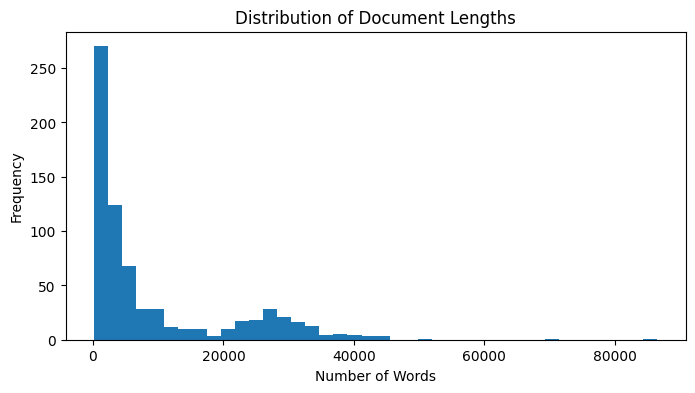

- Below is top 20 most frequent words in corpus documents -
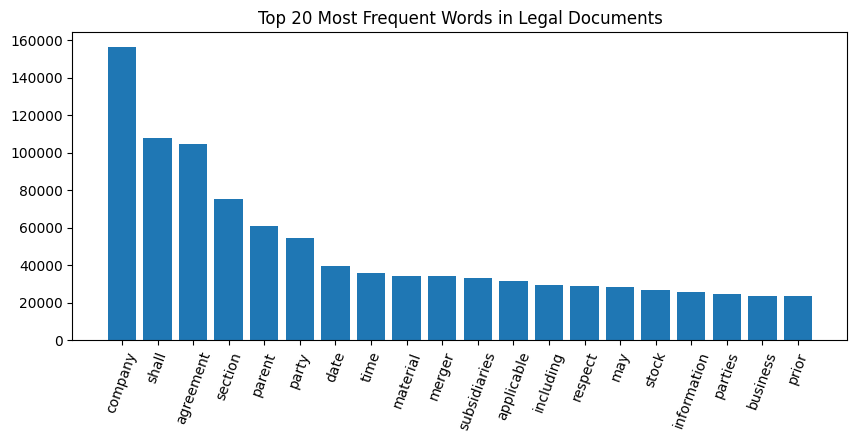

- Below is heatmap of similarity -
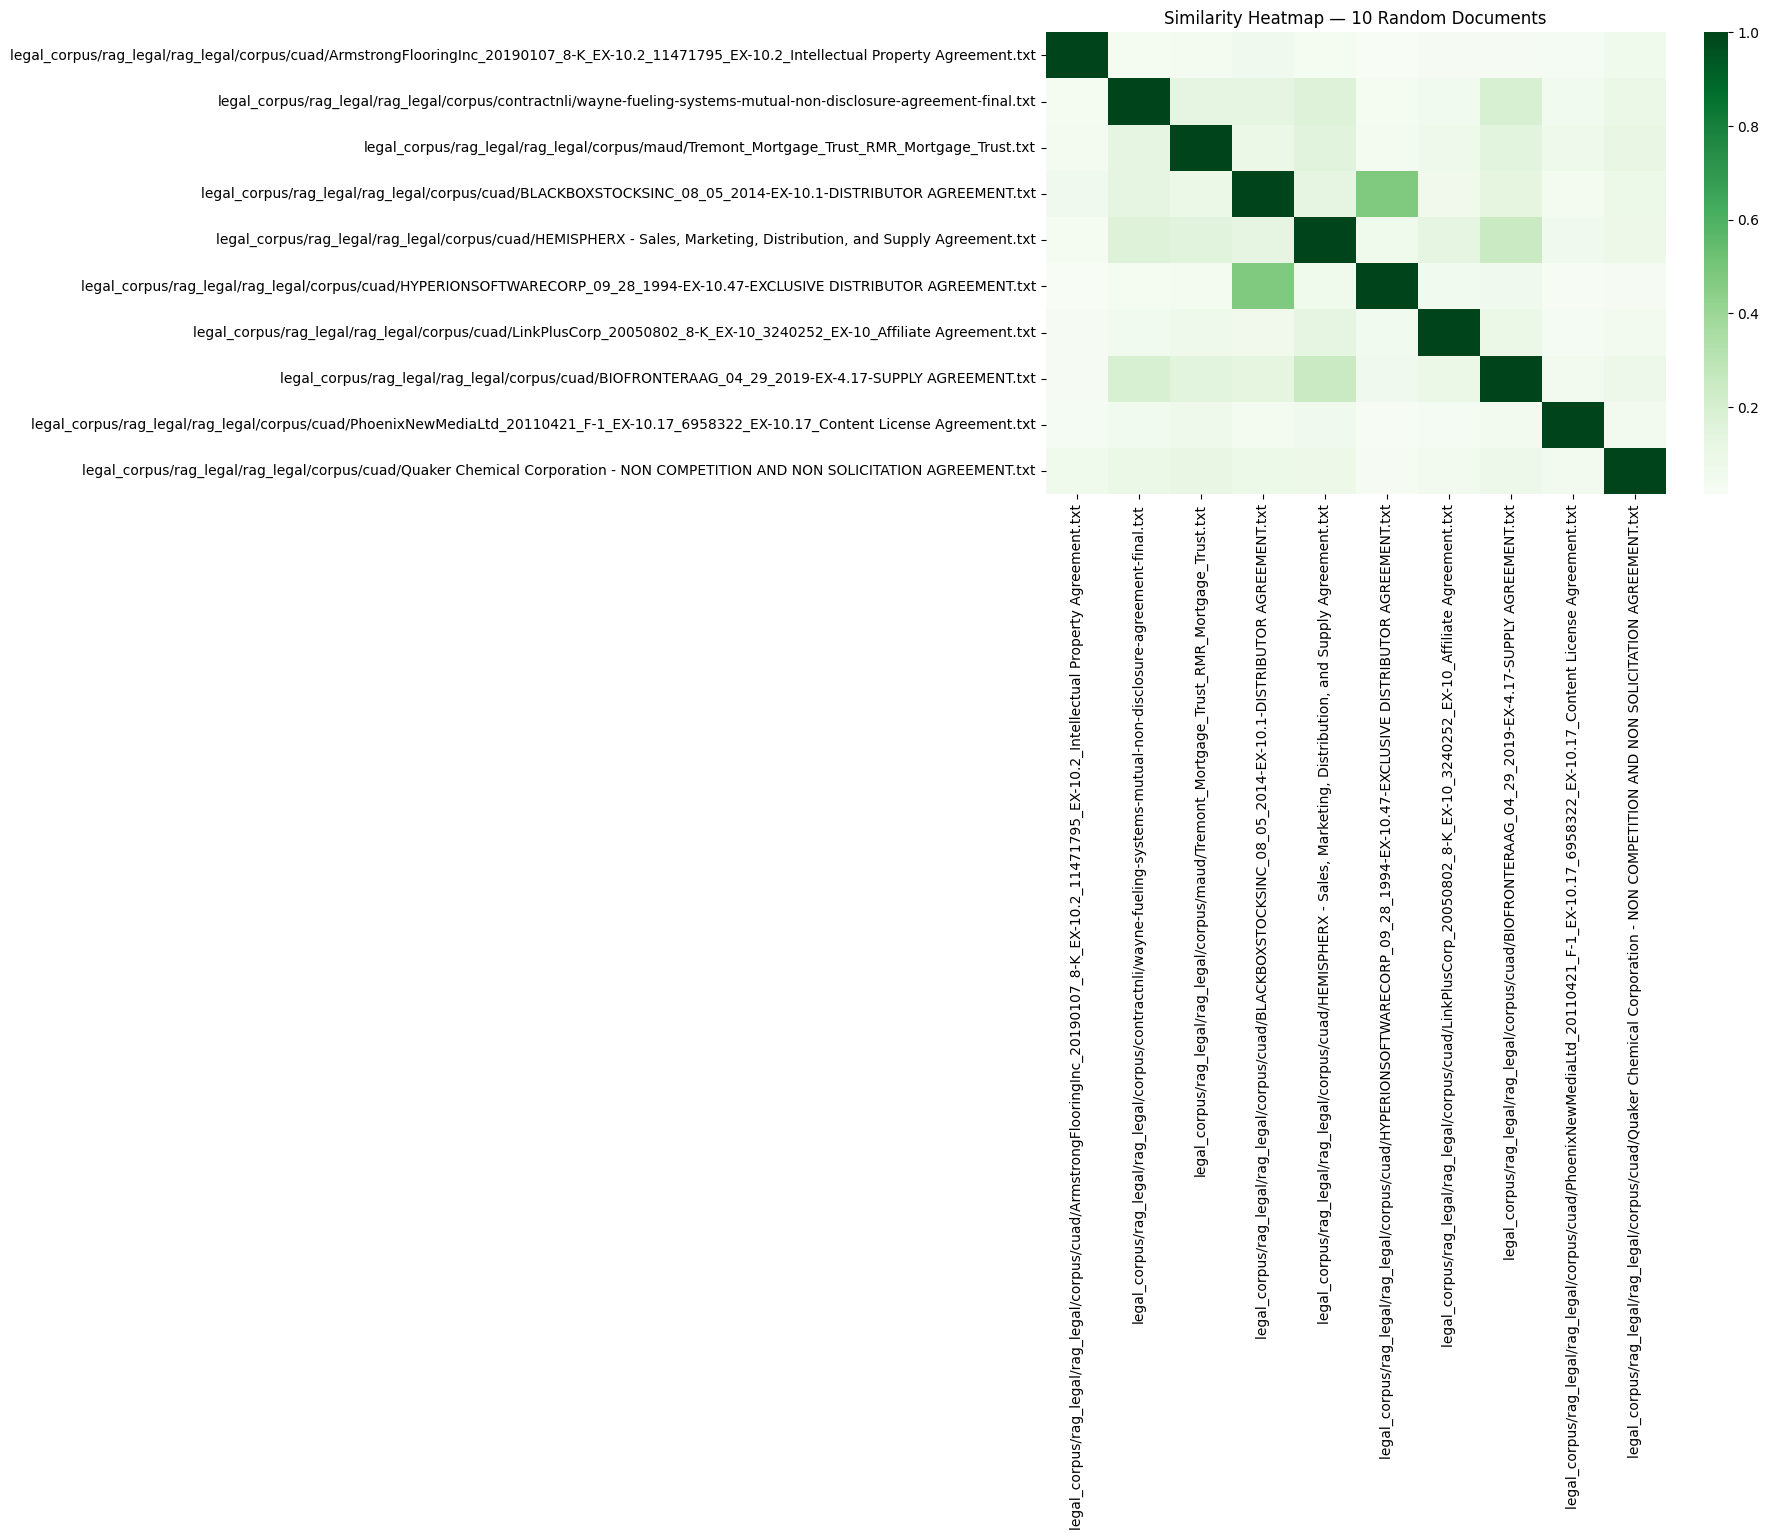

Faithfulness - This metric measures the factual consistency of the generated answer with the retrieved context. It checks how often the claims made by the LLM are actually supported by the documents it was given.

Answer Relevancy - This metric measures how well the generated answer directly addresses the user's original question. It assesses if the response is focused and helpful from the user's perspective.

Context Recall - This metric measures how much of the ground truth answer's necessary information was actually present within the retrieved documents. It evaluates if the retrieval system successfully found all the relevant facts needed to form a complete answer.

Context Precision - This metric measures the precision of the retrieval step—specifically, how relevant the top-ranked retrieved documents are to the user's query. It checks if the retrieved documents are useful "signal" rather than irrelevant "noise".

Based the evaluation we got below score for each factor and indicates we have scope to improve the performance of model.
1. Faithfulness: 0.1000 (10%)
2. Answer Relevancy: 0.0000 (0%)
3. Context Recall: 0.2481 (24.81%)
4. Context Precision: 0.1892 (18.92%)